In [1]:
import warnings
warnings.filterwarnings("ignore")

from src.acquire import get_zillow_data
from src.prepare import wrangle_zillow, geo_df, split_data
from src.sklearn24 import mean_absolute_percentage_error

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

lucario = ['#6EA4BB', '#C04C4B', '#464646', '#E7E7E6', '#F0DBA5']
sns.set_palette(sns.color_palette(lucario))

import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.feature_selection import SelectKBest, f_regression, RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.pipeline import make_pipeline

import eli5

[Modeling](#2)

In [2]:
df = get_zillow_data()
df.to_csv("data/sfr_2017.csv")
cutoff=2
df = pd.read_csv("data/sfr_2017.csv", index_col=0)

In [3]:
#WHY ISNT THIS HAPPENING WITH PREPARE??????????????
df=df.dropna(axis=0, subset=["taxvaluedollarcnt", "calculatedfinishedsquarefeet"])
df.shape[0]

38508

In [109]:
#incomplete records
38622-38508

114

In [5]:
X_train, X_test, X_val, y_train, y_test, y_val = wrangle_zillow(df, k=cutoff) #k specifies outlier clipping
X_train.info()

X_train, X_test, X_val, y_train, y_test, y_val
(23362, 400) (5007, 400) (5007, 400) (23362,) (5007,) (5007,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23362 entries, 26657 to 14293
Columns: 400 entries, bathroomcnt to 399675
dtypes: float64(5), int64(9), object(1), uint8(385)
memory usage: 11.4+ MB


In [5]:
X_train.county.value_counts()

Los Angeles    14179
Orange          6971
Ventura         2212
Name: county, dtype: int64

In [15]:
df.shape[0]-(len(y_train)+len(y_val)+len(y_test))

33376

In [17]:
y_train.describe()

count    2.336200e+04
mean     4.072733e+05
std      2.483619e+05
min      1.108900e+04
25%      2.207025e+05
50%      3.620395e+05
75%      5.431435e+05
max      1.312000e+06
Name: taxvalue, dtype: float64

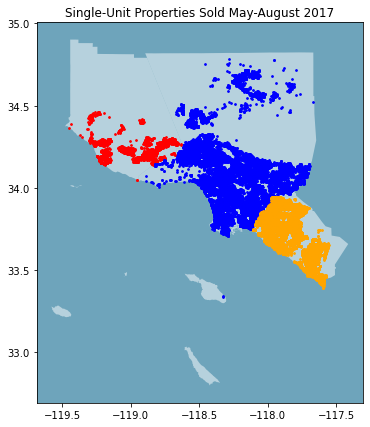

In [5]:
#https://gisdata-scag.opendata.arcgis.com/datasets/county-boundaries-scag-region/explore?filters=eyJBQ1JFUyI6WzY4Ny40OTYwMjEyOCwyNzUwNTIyLjMyXX0%3D&location=34.131659%2C-116.867850%2C7.00
file = 'data/County_Boundaries/County_Boundaries_%E2%80%93_SCAG_Region.shp'
geo_df, map_ = geo_df(X_train, y_train, file)

f, ax = plt.subplots(figsize=(11,7))
ax.set_facecolor(lucario[0])
map_.plot(ax=ax, alpha=.5, color='white')

geo_df[geo_df.county=='Ventura'].plot(ax=ax, markersize=3, color='red', label="Ventura")
geo_df[geo_df.county=='Los Angeles'].plot(ax=ax, markersize=3, color='blue', label="L.A.")
geo_df[geo_df.county=='Orange'].plot(ax=ax, markersize=3, color='orange', label="Orange")

plt.title("Single-Unit Properties Sold May-August 2017");
plt.savefig('img/geodf.png');

<img src="img/socal.png" width=300px>

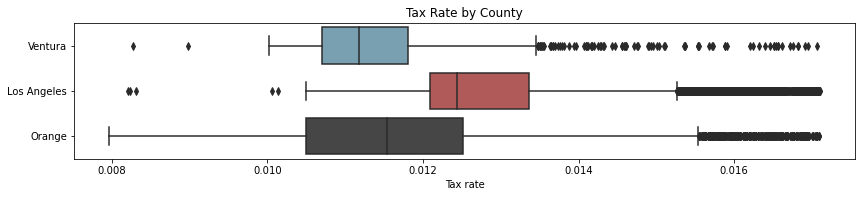

In [20]:
counties = ["Ventura", "Los Angeles", "Orange"]

plt.figure(figsize=(14, 2.5))
sns.boxplot(data=X_train, y='county', x='taxrate', order=counties)
plt.ylabel("")
plt.xlabel("Tax rate")
plt.title("Tax Rate by County")
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


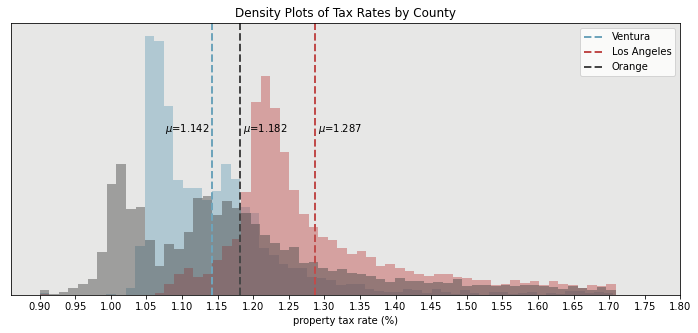

In [21]:
f, ax = plt.subplots(figsize=(12,5))
for i, county in enumerate(counties):
    ax.set_facecolor(lucario[3])
    plt.title("Density Plots of Tax Rates by County")
    plt.xlabel("property tax rate (%)")
    #so bins are the same width
    clipped = X_train.taxrate[X_train.county==county].clip(.009, .018)*100
    plt.axvline(clipped.mean(), color=lucario[i], linestyle='dashed', linewidth=2)
    
    la_mean = np.round(clipped[X_train.county=='Los Angeles'].mean(),3)
    ve_mean = np.round(clipped[X_train.county=='Ventura'].mean(),3)
    or_mean = np.round(clipped[X_train.county=='Orange'].mean(),3)
    plt.text(.004+la_mean, 6, f'$\mu$={la_mean}')
    plt.text(.004+or_mean, 6, f'$\mu$={or_mean}')
    plt.text(-.066+ve_mean, 6, f'$\mu$={ve_mean}')

    clipped.hist(bins=60, alpha=.45, density=True)
    plt.xticks(np.linspace(.9,1.8,19))
    plt.yticks([])
    plt.grid(False)
plt.legend(counties)
plt.savefig('img/taxrates.png')

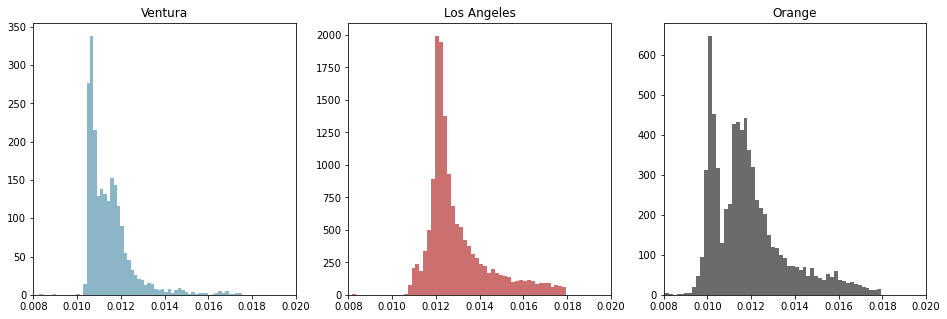

In [19]:
counties = ["Ventura", "Los Angeles", "Orange"]
plt.figure(figsize=(16,5))
for i, county in enumerate(counties):
    plot_number = i + 1 
    plt.subplot(1, len(counties), plot_number)
    plt.title(county)
    plt.xlim(.008, .02)
    X_train.taxrate[X_train.county==county].hist(bins=60, alpha=.8, color=lucario[i])
    plt.grid(False)

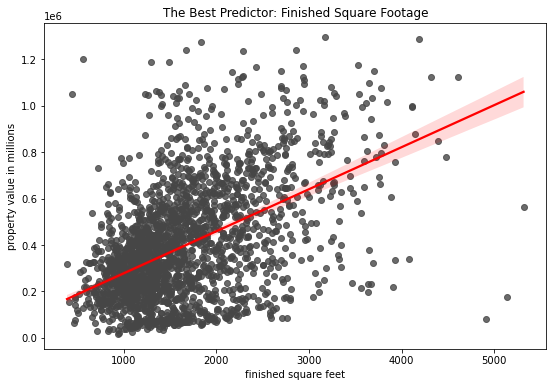

In [18]:
#heteroskedasticity
plt.figure(figsize=(9,6))
sns.regplot(x=X_train.finishedsqft[:2100].values, y=y_train[:2100],
            scatter_kws={"color": lucario[2]}, line_kws={"color": "red"},
            robust=True)
plt.title("The Best Predictor: Finished Square Footage")
plt.ylabel("property value in millions")
plt.xlabel("finished square feet")
plt.savefig("img/bestx.png")

## Hypotheses

H<sub>0</sub> Home values are independent of county.

H<sub>0</sub> Home values do not have a linear relationship with living-area ratio.

H<sub>0</sub> Home values are independent of year built.


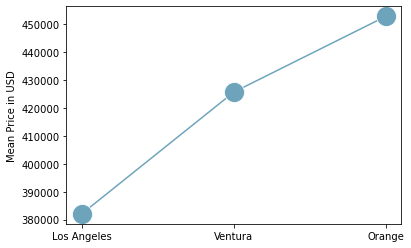

MannwhitneyuResult(statistic=13718420.5, pvalue=1.1956324823327659e-21)
MannwhitneyuResult(statistic=7250266.5, pvalue=1.1618967459166967e-05)
MannwhitneyuResult(statistic=40907982.0, pvalue=9.174213960805895e-93)


In [81]:
los = y_train[X_train.county=="Los Angeles"]
ora = y_train[X_train.county=="Orange"]
ven = y_train[X_train.county=="Ventura"]

l,o,v = los.mean(), ora.mean(), ven.mean()
sns.lineplot(y=[l,v,o], x=['Los Angeles','Ventura','Orange'], marker="o", markersize=20)
plt.ylabel("Mean Price in USD")
plt.savefig("img/meanprice.png")
plt.show()

print(stats.mannwhitneyu(ven, los))
print(stats.mannwhitneyu(ven, ora))
print(stats.mannwhitneyu(ora, los))

In [139]:
X_train.year

26657    1991
13970    1953
26976    1951
36646    1981
25067    1965
         ... 
23836    1980
37108    1954
8843     1990
16591    1965
14293    1959
Name: year, Length: 23362, dtype: int64

livingarearatio
Pearson correlation = 0.21153
p-value             = 0.00000



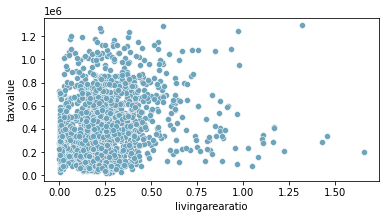

year
Pearson correlation = 0.20876
p-value             = 0.00000



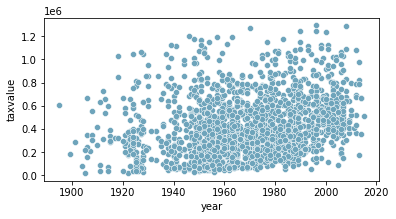

bathroomcnt
Pearson correlation = 0.39326
p-value             = 0.00000



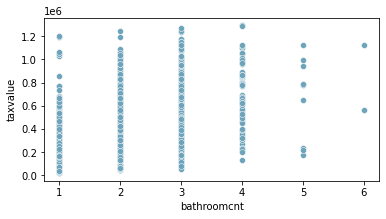

latitude
Pearson correlation = -0.13841
p-value             = 0.00000



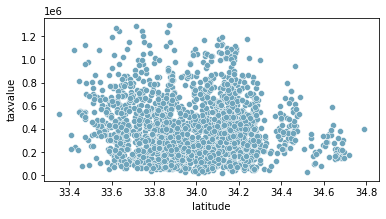

bedroomcnt
Pearson correlation = 0.27130
p-value             = 0.00000



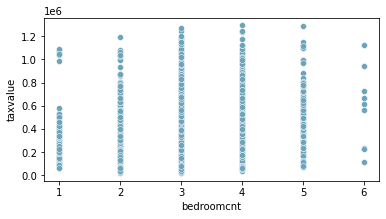

finishedsqft
Pearson correlation = 0.50873
p-value             = 0.00000



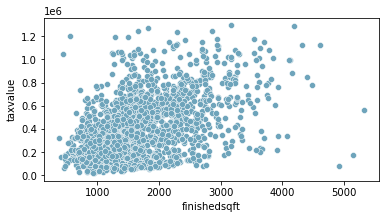

buildingqualitytypeid
Pearson correlation = 0.23168
p-value             = 0.00000



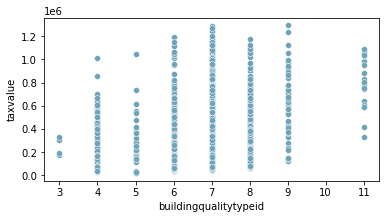

In [141]:
features = ['livingarearatio', 'year', 'bathroomcnt', 'latitude',
            'bedroomcnt', 'finishedsqft', 'buildingqualitytypeid']

for f in features:
    print(f)
    corr, p = stats.pearsonr(X_train[f], y_train)
    print(f'Pearson correlation = {corr:.5f}')
    print(f'p-value             = {p:.5f}\n')
    
    fig, ax = plt.subplots(figsize=(6,3))
    sns.scatterplot(x=X_train[f][:2000], y=y_train[:2000])
    plt.savefig(f"img/{f}.png")
    plt.show()

<a id='2'></a>
## Modeling

Zillow Prize FAQ:

Why did Zillow pick the log error instead of an absolute error metric such as RMSE?

Home sale prices have a **right skewed distribution** and are also **strongly heteroscedastic**, so **we need to use a relative error metric instead of an absolute metric** to ensure valuation models are not biased towards expensive homes. A relative error metric like the percentage error or log ratio error avoids these problems. While we report Zestimate errors in terms of percentages on Zillow.com because we believe that to be a more intuitive metric for consumers, we do not advocate using percentage error to evaluate models in Zillow Prize, as it may lead to biased models The log error is free of this bias problem and when using the natural logarithm, errors close to 1 approximate percentage errors quite closely.

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2635088

Now that we’ve identified the presence of heteroskedasticity in our data, what can we do about it? Recall that the two main consequences of heteroskedasticity are 1) ordinary least squares no longer produces the best estimators and 2) standard errors computed using least squares can be incorrect and misleading. Let’s first deal with the issue of incorrect standard errors.

When heteroskedasticity is present, the best linear unbiased estimator depends on the uknown σ2i. This estimator is referred to as the generalized least squares estimator. 

In [65]:
def rfe(X, y, k):
    """takes in the predictors, the target, and the number of features to select.
    and return the top k features based on the RFE class."""
    rfe = RFE(LinearRegression(), k)
    X_rfe = rfe.fit_transform(X, y)
    
    mask = rfe.support_
    rfe_features = X.loc[:, mask].columns.tolist()
    
    print(str(len(rfe_features)), 'selected features')
    print(rfe_features)

def select_kbest(X, y, k):
    """takes in the predictors (X), the target (y), and the number of features to select (k)
    and returns the names of the top k selected features based on the SelectKBest class."""
    # parameters: f_regression stats test, give me 8 features
    f_selector = make_pipeline(StandardScaler(), SelectKBest(f_regression, k=k))
    f_selector.fit(X, y)

    # boolean mask of whether the column was selected or not. 
    feature_mask = f_selector[1].get_support()

    # get list of top K features. 
    f_feature = X_train.iloc[:,feature_mask].columns.tolist()
    
    print(str(len(f_feature)), 'features')
    print(f_feature)

In [66]:
k=5
select_kbest(X_train, y_train, k=k)

5 features
['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'finishedsqft', 'livingarearatio']


In [142]:
y_pred = np.zeros((len(y_train),)) + y_train.mean()
print("Evaluating the Mean Model (in sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_train, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_train, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_train, y_pred),2)}")
y_pred = np.zeros((len(y_val),)) + y_train.mean()
print("Evaluating the Mean Model (out of sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_val, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_val, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),2)}")

Evaluating the Mean Model (in sample):
  RMSE: 248000
  MAPE: 0.91
  R^2: 0.0
Evaluating the Mean Model (out of sample):
  RMSE: 245000
  MAPE: 0.9
  R^2: -0.0


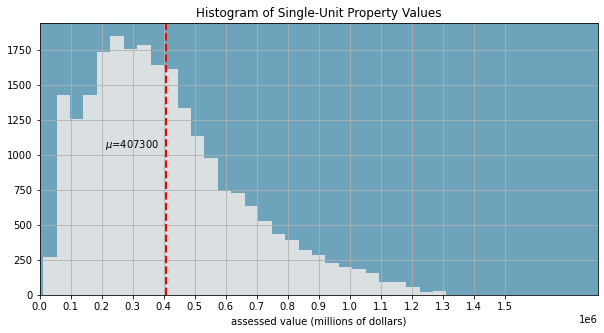

In [93]:
f, ax = plt.subplots(figsize=(10,5))
ax.set_facecolor(lucario[0])
plt.title("Histogram of Single-Unit Property Values")
plt.xlabel("assessed value (millions of dollars)")
plt.xlim(0, 1.8e6)
plt.axvline(y_train.mean(), color='red', linestyle='dashed', linewidth=2)
plt.xticks(np.linspace(0,1.5e6,16))
plt.text(2.1e5, 1050, f'$\mu$={int(np.round(y_train.mean(),-2))}')
#plt.text(2.2e5, 900, f'$\sigma$={int(np.round(y_train.std(),-2))}')
#plt.text(2.3e5, 900, f'n={len(y_train)}')

y_train.hist(bins=30, alpha=.9, color=lucario[3])
plt.savefig('img/meanhist.png')

In [143]:
xvars = ['finishedsqft', 'bedroomcnt']
reg_mvp = LinearRegression().fit(X_train[xvars], y_train)
y_pred = reg_mvp.predict(X_train[xvars])

print("Evaluating the MVP Model (in sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_train, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_train, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_train, y_pred),2)}")

y_pred = reg_mvp.predict(X_val[xvars])

print("Evaluating the MVP Model (out of sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_val, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_val, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),2)}")

Evaluating the MVP Model (in sample):
  RMSE: 212000
  MAPE: 0.75
  R^2: 0.27
Evaluating the MVP Model (out of sample):
  RMSE: 211000
  MAPE: 0.76
  R^2: 0.26


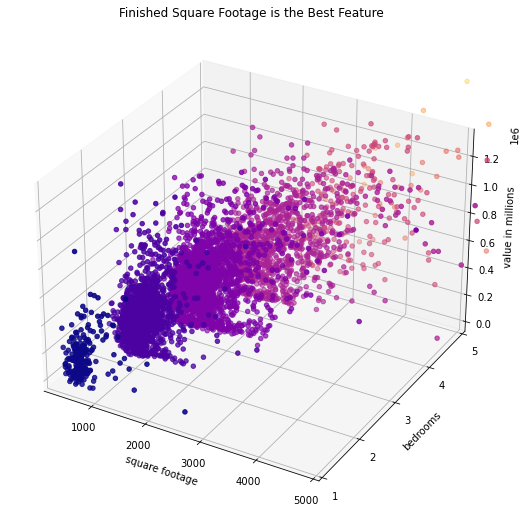

In [95]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection = '3d')

y = X_val['bedroomcnt']
plt.yticks(range(1,6))
plt.ylim(1,5)
x = X_val['finishedsqft']
plt.xlim(200,5000)
z = y_val
ax.set_title("Finished Square Footage is the Best Feature")
ax.set_ylabel("bedrooms")
ax.set_xlabel("square footage")
ax.set_zlabel("value in millions")
 
# plot the plane
#ax.plot_surface(x, y, z, alpha=0.5)
ax.scatter(x, y, z, c=y, cmap='plasma')
plt.savefig('img/mvp.png')
plt.show()

## Drop leaky data

In [10]:
X_train.columns[:25]

Index([               'Orange',               'Ventura',
                 'bathroomcnt',            'bedroomcnt',
       'buildingqualitytypeid',          'finishedsqft',
                        'year',              'latitude',
             'livingarearatio',                   95982,
                         95983,                   95984,
                         95985,                   95986,
                         95987,                   95988,
                         95989,                   95991,
                         95992,                   95993,
                         95994,                   95995,
                         95996,                   95997,
                         95998],
      dtype='object')

In [8]:
train_co = pd.get_dummies(X_train.county, drop_first=True)
val_co = pd.get_dummies(X_val.county, drop_first=True)
test_co = pd.get_dummies(X_test.county, drop_first=True)

X_train = pd.concat([train_co, X_train], axis=1)
X_val = pd.concat([val_co, X_val], axis=1)
X_test = pd.concat([test_co, X_test], axis=1)

In [9]:
cols = ['county', 'landtaxvalue', 'structuretaxvalue', 'taxamount', 'taxrate', 'regionidzip', 'longitude', 'lotsqft']
X_train.drop(columns=cols, inplace=True)
X_val.drop(columns=cols, inplace=True)
X_test.drop(columns=cols, inplace=True)

In [96]:
xvars=features
reg_multi = make_pipeline(StandardScaler(), LassoLars())
reg_multi.fit(X_train[xvars], y_train)
y_pred = reg_multi.predict(X_train[xvars])

print("Evaluating the Multilinear Model (in sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_train, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_train, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_train, y_pred),2)}")

y_pred = reg_multi.predict(X_val[xvars])

print("Evaluating the Multilinear Model (out of sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_val, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_val, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),2)}")

Evaluating the Multilinear Model (in sample):
  RMSE: 208000
  MAPE: 0.72
  R^2: 0.3
Evaluating the Multilinear Model (out of sample):
  RMSE: 206000
  MAPE: 0.73
  R^2: 0.29


In [97]:
reg_tw = make_pipeline(StandardScaler(), TweedieRegressor(power=2, alpha=2))
reg_tw.fit(X_train[xvars], y_train)
y_pred = reg_tw.predict(X_val[xvars])

print("Evaluating the Bad Model:")
print(f"  RMSE: {int(np.round(mean_squared_error(y_test, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_test, y_pred),2)}")

Evaluating the Bad Model:
  RMSE: 253000
  MAPE: 0.84
  R^2: -0.09


In [24]:
#polynomials didn't help
#X_train = pd.concat([X_train.iloc[:,:7]**2, X_train], axis=1)
#X_val = pd.concat([X_val.iloc[:,:7]**2, X_val], axis=1)
#X_test = pd.concat([X_test.iloc[:,:7]**2, X_test], axis=1)

In [11]:
reg_lars = make_pipeline(StandardScaler(), LassoLars()) #use regular and it dont work
reg_lars.fit(X_train, y_train)
y_pred = reg_lars.predict(X_train)

print("Evaluating the Bread Model (in sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_train, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_train, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_train, y_pred),2)}")

y_pred = reg_lars.predict(X_val)

print("Evaluating the Bread Model (out of sample):")
print(f"  RMSE: {int(np.round(mean_squared_error(y_val, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_val, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_val, y_pred),2)}")

Evaluating the Bread Model (in sample):
  RMSE: 188000
  MAPE: 0.65
  R^2: 0.43
Evaluating the Bread Model (out of sample):
  RMSE: 190000
  MAPE: 0.66
  R^2: 0.4


In [29]:
def myprediction(z, sqft):
    #print(f'finished sqft.: {sqft}')    
    #print(f'zip: {z}')
    
    house = np.zeros([1, zips_sqft_test.shape[1]])
    house[0,-1] = sqft
    
    haszip = False
    for i, c in enumerate(zips_sqft_test.columns):
        if z==c:
            haszip = True
            house[0,i] = 1
    
    if haszip == False:
        #if zip not in model, it defaults to 96010
        house[0,27] = 1
    
    pred = np.round(reg_lars.predict(house)[0],0)
    #print(f'\npredicted value: {pred}\n')
    return pred

def mypredict(X):
    preds = []
    for i in range(len(X)):
        z = X.regionidzip.iloc[i]
        s = X.finishedsqft.iloc[i]
        preds.append(myprediction(z, s))
    return preds

In [12]:
#y_pred = mypredict(X_test)
y_pred = reg_lars.predict(X_test)

print("Evaluating the Final Model on test data:")
print(f"  RMSE: {int(np.round(mean_squared_error(y_test, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_test, y_pred),2)}")

#baseline
y_pred = np.zeros((len(y_test),)) + y_train.mean() #make sure you use training mean!
print("Evaluating the Mean Model on test data:")
print(f"  RMSE: {int(np.round(mean_squared_error(y_test, y_pred, squared=False),-3))}")
print(f"  MAPE: {np.round(mean_absolute_percentage_error(y_test, y_pred),2)}")
print(f"  R^2: {np.round(r2_score(y_test, y_pred),2)}")

Evaluating the Final Model on test data:
  RMSE: 188000
  MAPE: 0.63
  R^2: 0.4
Evaluating the Mean Model on test data:
  RMSE: 243000
  MAPE: 0.85
  R^2: -0.0


In [38]:
#96010 is an "average" zip code
myprediction(0, 0)

145044.0

In [31]:
import pickle

#with open('flask/model.pkl', 'wb') as f:  
#    pickle.dump(reg_lars, f)
    
with open('flask/model.pkl', 'rb') as f:
    reg_lars = pickle.load(f)
    
#pd.DataFrame(zips_sqft_test.columns).to_csv('flask/columns.csv',
#                                     index=False)

In [41]:
reg_lars[1].intercept_

393563.0236688979

In [26]:
print(zips_sqft_test.columns[25:35])
print(np.mean(reg_lars[1].coef_))
print(np.round(reg_lars[1].coef_,-3)[25:35])

Index([96008, 96009, 96010, 96012, 96013, 96014, 96015, 96016, 96017, 96018], dtype='object')
1266.6403948406503
[ 5000.  5000.  1000.    -0. -1000. -2000.  2000.  3000.  7000. -4000.]


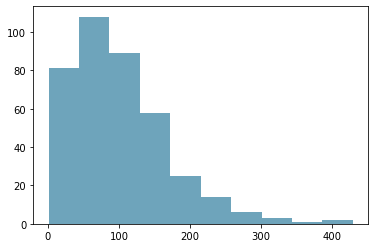

In [43]:
plt.hist(df.regionidzip.value_counts());

Takeaways

Precision of metrics:
Changing random state changed RMSE by a few thousand (all metrics by 1-2 percent)

Defining outliers makes a significant imact on model. Defining single-unit makes a noticable impact.

Mean percentage error is a good way to account for heteroskedasticity in data because it scales the error term proportionately.

Polynomial terms become impractical when the parmeter space is high. A neural network would be a better choice to increase model complexity.



In [28]:
mean = 393600

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)

y_val['mean'] = mean
y_train['mean'] = mean

#y_val['pred_lm'] = reg_multi.predict(X_val[xvars])
#y_train['pred_lm'] = reg_multi.predict(X_train[xvars])

y_val['pred_lars'] =  reg_lars.predict(X_val)
y_train['pred_lars'] =  reg_lars.predict(X_train)

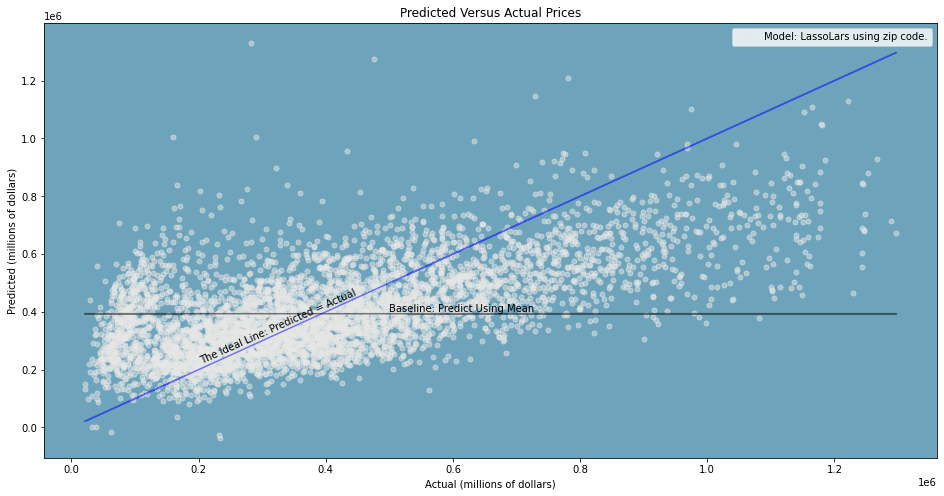

In [136]:
f, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor(lucario[0])

plt.plot(y_val.taxvalue, y_val['mean'], alpha=.5, color="black", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (5e5, 4e5))
plt.plot(y_val.taxvalue, y_val.taxvalue, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (2e5, 2.2e5), rotation=24)
plt.scatter(y_val.taxvalue, y_val.pred_lars, alpha=.5, color=lucario[3], s=25, label="Model: LassoLars using zip code.")

plt.legend()
plt.xlabel("Actual (millions of dollars)")
plt.ylabel("Predicted (millions of dollars)")
plt.title("Predicted Versus Actual Prices")
plt.savefig("img/preds.png")
plt.show()

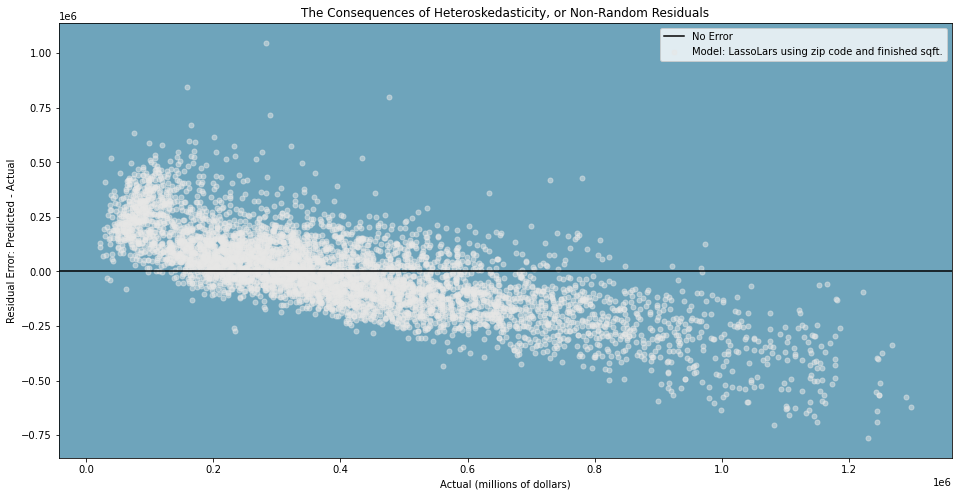

In [137]:
f, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor(lucario[0])

plt.axhline(label="No Error", color="black")
#plt.scatter(y_val.taxvalue, y_val.pred_lm-y_val.taxvalue, alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_val.taxvalue, y_val.pred_lars-y_val.taxvalue, alpha=.5, color=lucario[3], s=25, label="Model: LassoLars using zip code and finished sqft.")
plt.legend()
plt.xlabel("Actual (millions of dollars)")
plt.ylabel("Residual Error: Predicted - Actual")
plt.title("The Consequences of Heteroskedasticity, or Non-Random Residuals")
plt.savefig("img/resid.png")
plt.show()

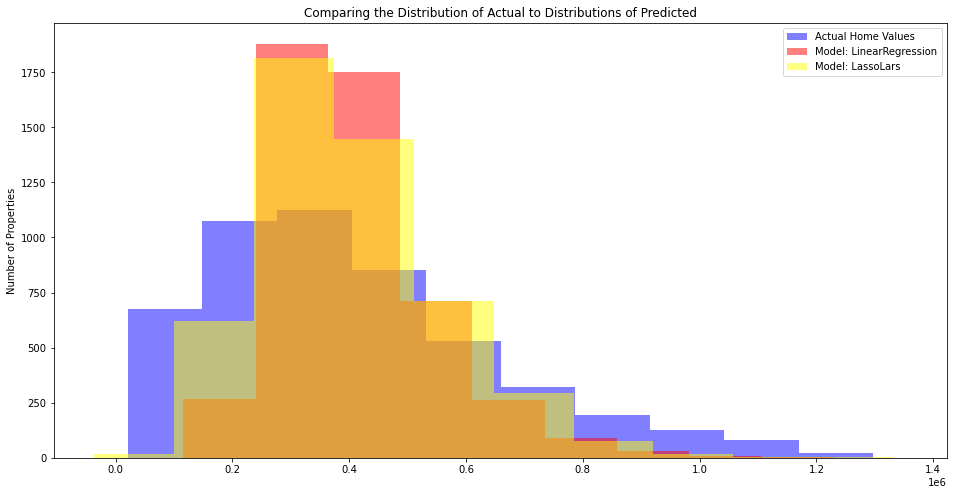

In [122]:
plt.figure(figsize=(16,8))
plt.hist(y_val.taxvalue, color='blue', alpha=.5, label="Actual Home Values")
plt.hist(y_val.pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_val.pred_lars, color='yellow', alpha=.5, label="Model: LassoLars")
plt.xlabel("")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual to Distributions of Predicted")
plt.legend()
plt.show()